##  Coal Resources Analysis 

## Extracting the data using the API

In [1]:
import requests
import pandas as pd

def fetch_data(url, headers, max_records):
    data_accumulator = []
    offset = 0
    while True:
        response = requests.get(f"{url}&offset={offset}", headers=headers)
        if response.status_code == 200:
            data = response.json()['response']['data']
            if not data:
                break
            data_accumulator.extend(data)
            offset += len(data)
            if len(data_accumulator) >= max_records:
                break
        else:
            print("Failed to fetch data:", response.status_code)
            break
    return pd.DataFrame(data_accumulator)

# API URL and headers
url = 'https://api.eia.gov/v2/coal/shipments/plant-aggregates/data/?frequency=annual&data[0]=ash-content&data[1]=heat-content&data[2]=price&data[3]=quantity&data[4]=sulfur-content&sort[0][column]=period&sort[0][direction]=desc'
headers = {
    'X-API-KEY': 'MB7EGjS54VIQfq1cPzgeyutY4fsUiBlnYewlcVIV',
}

# Fetch up to 20000 records
df = fetch_data(url, headers, 20500)
print(df)


      period location     plantStateDescription plant              plantName  \
0       2023       WY                   Wyoming  6068  Jeffrey Energy Center   
1       2023       WY                   Wyoming  6064          Nearman Creek   
2       2023       ND              North Dakota  6030             Coal Creek   
3       2023       ND              North Dakota  6030             Coal Creek   
4       2023       WY                   Wyoming  6009            White Bluff   
...      ...      ...                       ...   ...                    ...   
20401   2008      WVS  West Virginia (Southern)  1353              Big Sandy   
20402   2008       OH                      Ohio  1356                  Ghent   
20403   2008       IL                  Illinois  1357            Green River   
20404   2008      KYE           Kentucky (East)  1361                 Tyrone   
20405   2008       IL                  Illinois  1364             Mill Creek   

      rank coalRankDescription ash-cont

In [14]:
df.shape

(20406, 17)

# Importing the necessary libraries

In [8]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd         # For data manipulation
import numpy as np          # For numerical operations
import matplotlib.pyplot as plt  # For plotting basic charts
import seaborn as sns            # For more advanced and aesthetic statistical visualizations
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # For normalizing or scaling the data
from sklearn.model_selection import train_test_split            # For splitting the dataset into training and testing sets
from sklearn.linear_model import LinearRegression               # For regression models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # For ensemble methods
from sklearn.metrics import mean_squared_error, r2_score         # For evaluating model performance
from sklearn.decomposition import PCA                           # For Principal Component Analysis
from sklearn.cluster import KMeans                              # For clustering analysis


## Data Cleaning

In [15]:
df.shape

(20406, 17)

## Dropping irrelevant columns
Dropping irrelevant columns is an essential step in data cleaning to ensure that the dataset is optmized for analysis.
Dropping irrelevant columns like `ash-content-units`, `heat-content-units`, `price-units`, `quantity-units`, `sulfur-content-units`, `location` as the units are not needed for the analysis

In [16]:
# Dropping unwanted columns
columns_to_drop = ['location','ash-content-units', 'heat-content-units', 'price-units', 'quantity-units', 'sulfur-content-units']
df = df.drop(columns=columns_to_drop)

# Display the cleaned DataFrame
print(df.head())


  period plantStateDescription plant              plantName rank  \
0   2023               Wyoming  6068  Jeffrey Energy Center  TOT   
1   2023               Wyoming  6064          Nearman Creek  TOT   
2   2023          North Dakota  6030             Coal Creek  LIG   
3   2023          North Dakota  6030             Coal Creek  TOT   
4   2023               Wyoming  6009            White Bluff  TOT   

  coalRankDescription ash-content heat-content  price quantity sulfur-content  
0                 All        5.47         8615  28.82  5244557            .29  
1                 All        4.57         8720   34.9   607819            .21  
2             Lignite       10.32         6315  25.59  6448995            .58  
3                 All       10.32         6315  25.59  6448995            .58  
4                 All        4.66         8868  40.04  2377028            .22  


## Handling Missing values

### Checking for Missing values

In [17]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)


period                    0
plantStateDescription     0
plant                     0
plantName                 0
rank                      0
coalRankDescription       0
ash-content               0
heat-content              0
price                    12
quantity                  0
sulfur-content            0
dtype: int64


### Dropping rows with missing `price` values as the price column is critical and it should not be filled with an estimated data

In [19]:
# 
df = df.dropna(subset=['price'])
print(df.isnull().sum())  # Checking again for missing values 


period                   0
plantStateDescription    0
plant                    0
plantName                0
rank                     0
coalRankDescription      0
ash-content              0
heat-content             0
price                    0
quantity                 0
sulfur-content           0
dtype: int64


## Ensuring Data Types are correct or not

In [20]:
# Check the current data types
print(df.dtypes)


period                   object
plantStateDescription    object
plant                    object
plantName                object
rank                     object
coalRankDescription      object
ash-content              object
heat-content             object
price                    object
quantity                 object
sulfur-content           object
dtype: object


#### Converting the numeric columns to float data type

In [22]:
# Converting the specified columns to float
columns_to_convert = ['ash-content', 'heat-content', 'price', 'quantity', 'sulfur-content']

df[columns_to_convert] = df[columns_to_convert].astype(float)

print(df.dtypes)


period                    object
plantStateDescription     object
plant                     object
plantName                 object
rank                      object
coalRankDescription       object
ash-content              float64
heat-content             float64
price                    float64
quantity                 float64
sulfur-content           float64
dtype: object


# Optional handling for outlier 

In [24]:

# def detect_outliers_iqr(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
    
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    
#    
#     outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
#     return outliers

# 
# columns_to_check = ['ash-content', 'heat-content', 'price', 'quantity', 'sulfur-content']

# 
# for column in columns_to_check:
#     outliers = detect_outliers_iqr(df, column)
#     print(f"Outliers detected in {column}:")
#     print(outliers)

# 
# df_no_outliers = df.copy()
# for column in columns_to_check:
#     Q1 = df_no_outliers[column].quantile(0.25)
#     Q3 = df_no_outliers[column].quantile(0.75)
#     IQR = Q3 - Q1
    
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    
#     
#     df_no_outliers = df_no_outliers[(df_no_outliers[column] >= lower_bound) & (df_no_outliers[column] <= upper_bound)]

# print("Data after removing outliers:")
# print(df_no_outliers.describe())


Outliers detected in ash-content:
      period      plantStateDescription  plant  \
27      2023                 New Mexico   2442   
32      2023                   Illinois  55856   
35      2023                   Maryland  10678   
113     2023                 New Mexico   2442   
122     2023  Pennsylvania (Anthracite)  54634   
...      ...                        ...    ...   
20233   2008  Pennsylvania (Bituminous)   3152   
20275   2008                      Texas   6183   
20330   2008                      Texas   6648   
20365   2008  Pennsylvania (Bituminous)  10143   
20369   2008  Pennsylvania (Bituminous)  10678   

                                   plantName rank coalRankDescription  \
27                              Four Corners  TOT                 All   
32          Prairie State Generating Station  BIT          Bituminous   
35     AES Warrior Run Cogeneration Facility  BIT          Bituminous   
113                             Four Corners  SUB       Subbituminous   


In [47]:
df.drop_duplicates

<bound method DataFrame.drop_duplicates of       period     plantStateDescription plant              plantName rank  \
0       2023                   Wyoming  6068  Jeffrey Energy Center  TOT   
1       2023                   Wyoming  6064          Nearman Creek  TOT   
2       2023              North Dakota  6030             Coal Creek  LIG   
3       2023              North Dakota  6030             Coal Creek  TOT   
4       2023                   Wyoming  6009            White Bluff  TOT   
...      ...                       ...   ...                    ...  ...   
20401   2008  West Virginia (Southern)  1353              Big Sandy  BIT   
20402   2008                      Ohio  1356                  Ghent  TOT   
20403   2008                  Illinois  1357            Green River  TOT   
20404   2008           Kentucky (East)  1361                 Tyrone  BIT   
20405   2008                  Illinois  1364             Mill Creek  TOT   

      coalRankDescription  ash-content  heat

### 1. Distribution of Ash Content
The ash content distribution provides insights into the quality of coal, with higher ash content generally indicating lower fuel quality. This histogram helps identify the most common ash content levels across different coal shipments, revealing how coal quality varies in the dataset.

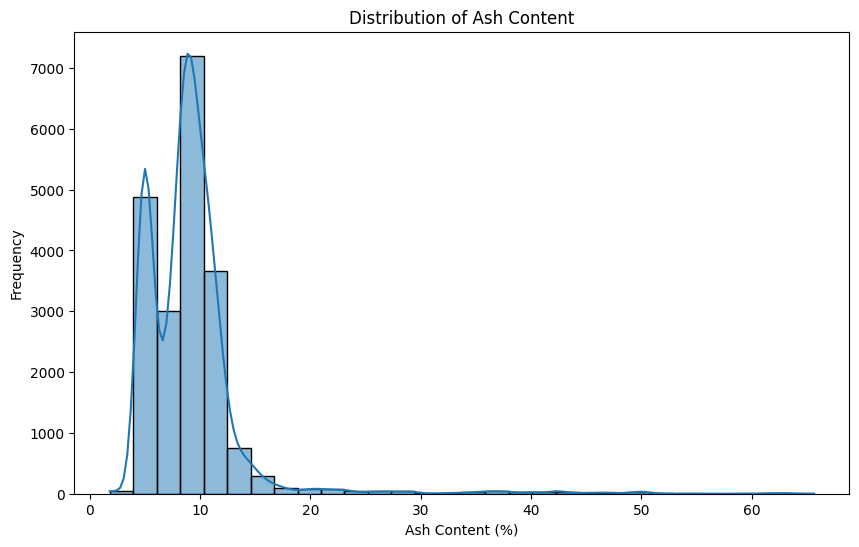

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(df['ash-content'], bins=30, kde=True)
plt.title('Distribution of Ash Content')
plt.xlabel('Ash Content (%)')
plt.ylabel('Frequency')
plt.show()


### 2. Annual Trend of Coal Price
This line plot illustrates how the average price of coal has changed over time. It helps identify any trends or fluctuations in the coal market.


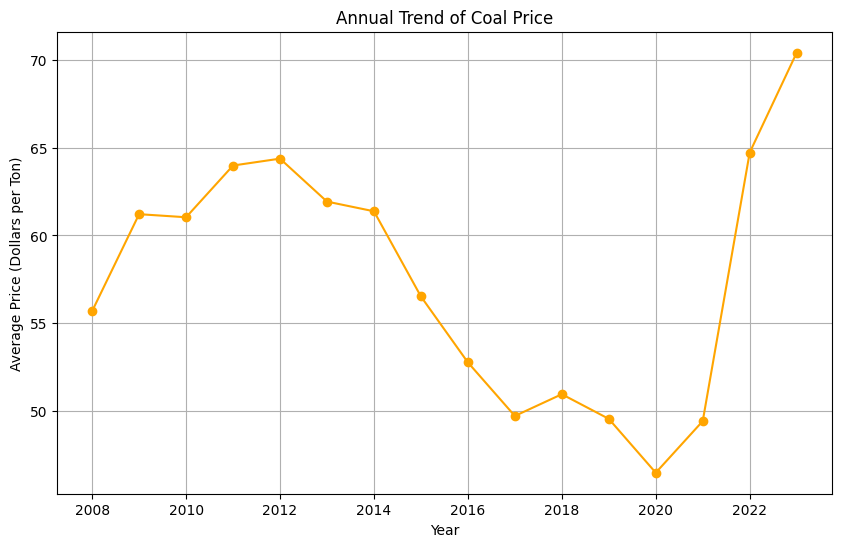

In [30]:
price_trend = df.groupby('period')['price'].mean()
plt.figure(figsize=(10, 6))
price_trend.plot(kind='line', marker='o', color='orange')
plt.title('Annual Trend of Coal Price')
plt.xlabel('Year')
plt.ylabel('Average Price (Dollars per Ton)')
plt.grid(True)
plt.show()


### 3. Heat Content vs. Price
This scatter plot shows the relationship between heat content and price. It helps identify whether higher heat content coal is generally more expensive.

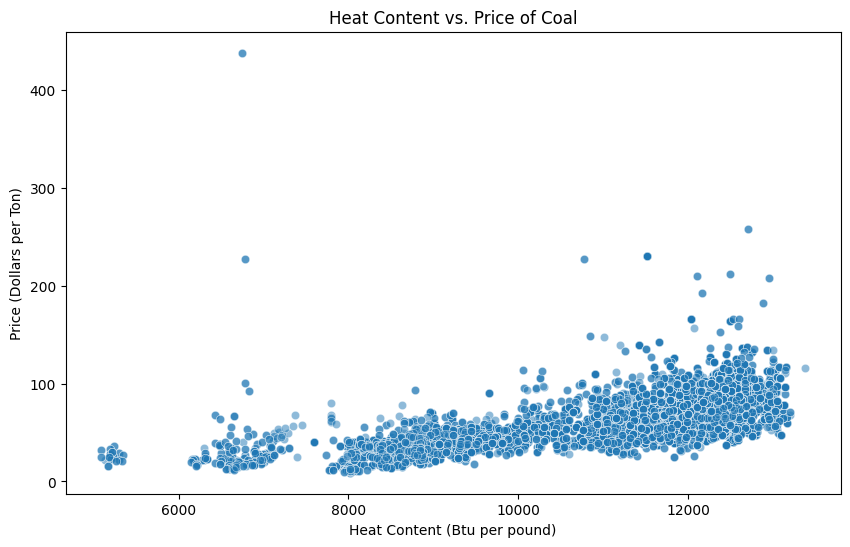

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='heat-content', y='price', data=df, alpha=0.5)
plt.title('Heat Content vs. Price of Coal')
plt.xlabel('Heat Content (Btu per pound)')
plt.ylabel('Price (Dollars per Ton)')
plt.show()


### 4. Sulfur Content by Coal Rank
The box plot highlights the variation of sulfur content across different coal ranks, showing the median, quartiles, and potential outliers for each rank.



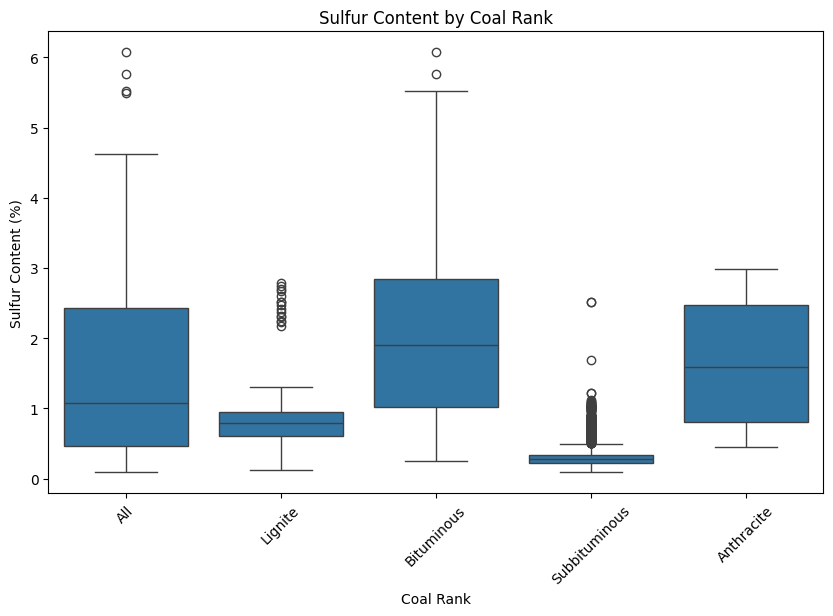

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='coalRankDescription', y='sulfur-content', data=df)
plt.title('Sulfur Content by Coal Rank')
plt.xlabel('Coal Rank')
plt.ylabel('Sulfur Content (%)')
plt.xticks(rotation=45)
plt.show()


### 5. Total Quantity of Coal by State 

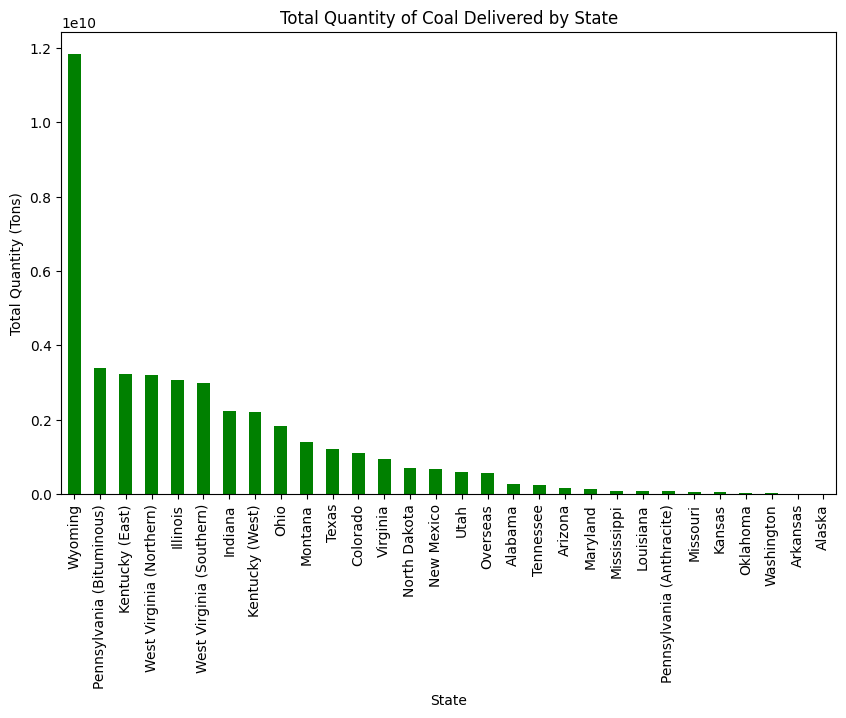

In [33]:
state_quantity = df.groupby('plantStateDescription')['quantity'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
state_quantity.plot(kind='bar', color='green')
plt.title('Total Quantity of Coal Delivered by State')
plt.xlabel('State')
plt.ylabel('Total Quantity (Tons)')
plt.xticks(rotation=90)
plt.show()


### 6. Coal Rank by Year
The stacked bar plot shows the distribution of coal ranks (such as bituminous, lignite, etc.) across different years. It highlights how the composition of coal shipments has evolved.

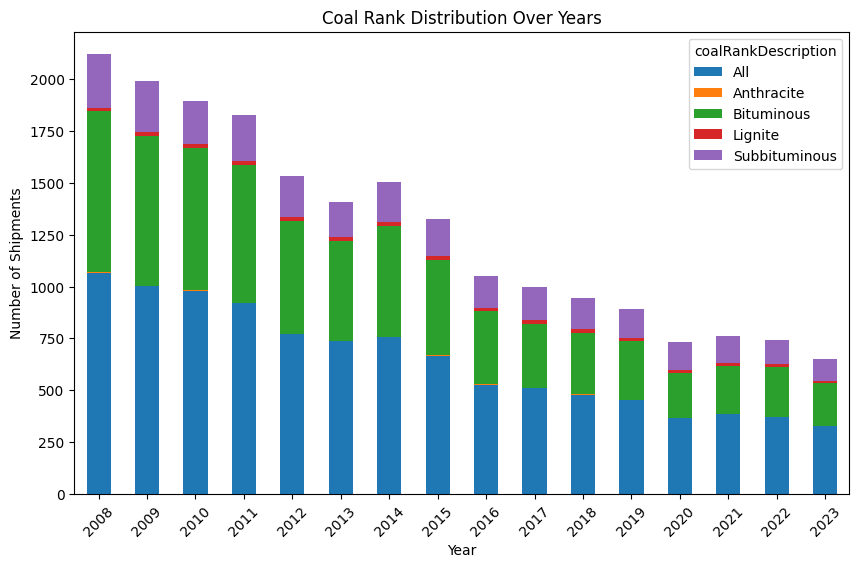

In [36]:
coal_rank_year = df.groupby(['period', 'coalRankDescription']).size().unstack()
coal_rank_year.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Coal Rank Distribution Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Shipments')
plt.xticks(rotation=45)
plt.show()


### 7. Heat Content Distribution by Coal Rank
The violin plot shows the distribution of heat content for each coal rank. It provides both the range and density of the data, offering more insights than a box plot alone.

C:\Users\rahul\AppData\Local\Temp\ipykernel_39276\3115755383.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='coalRankDescription', y='heat-content', data=df,
C:\Users\rahul\AppData\Local\Temp\ipykernel_39276\3115755383.py:8: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='coalRankDescription', y='heat-content', data=df,


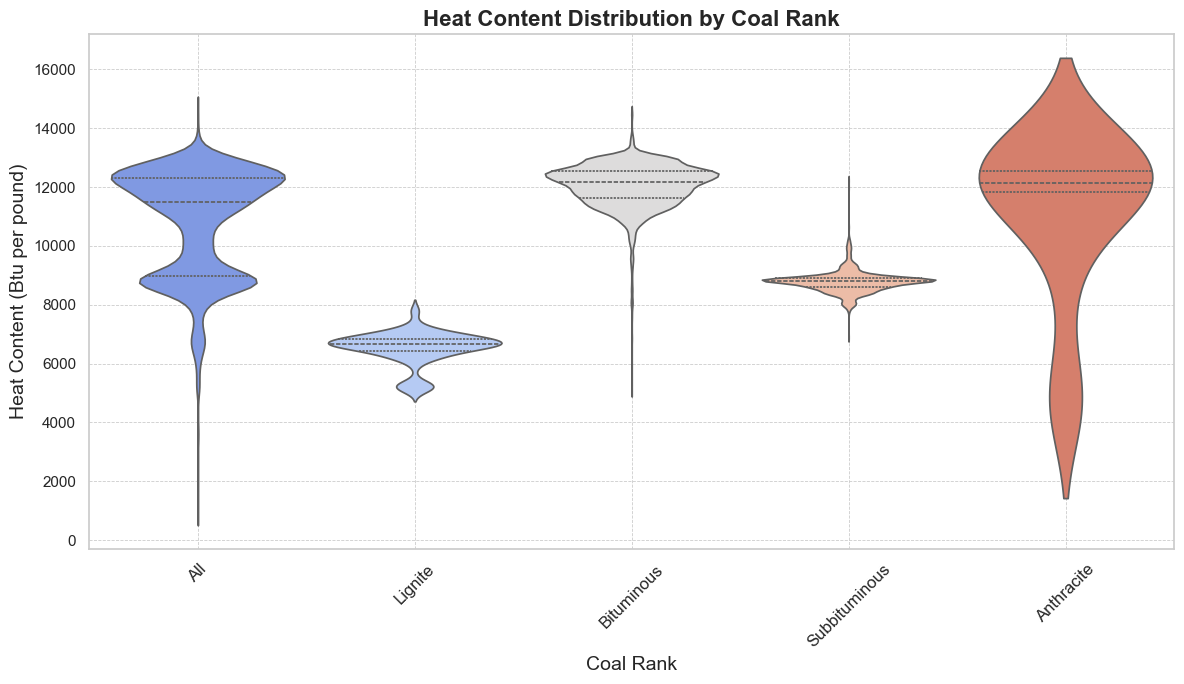

In [38]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure with custom size
plt.figure(figsize=(12, 7))

# Plot the violin plot with a color palette
sns.violinplot(x='coalRankDescription', y='heat-content', data=df, 
               palette='coolwarm', inner='quartile', scale='width')

# Adding title and labels with custom fonts and size
plt.title('Heat Content Distribution by Coal Rank', fontsize=16, fontweight='bold')
plt.xlabel('Coal Rank', fontsize=14)
plt.ylabel('Heat Content (Btu per pound)', fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

# Adding grid lines to the plot
plt.grid(True, linestyle='--', linewidth=0.6)

# Add some padding around the plot
plt.tight_layout()

# Display the plot
plt.show()

## 8. Heatmap of Correlation Between Numeric Features 
This heatmap shows the correlation between numeric variables in your dataset, allowing you to easily identify relationships between features such as heat content, price, and sulfur content.

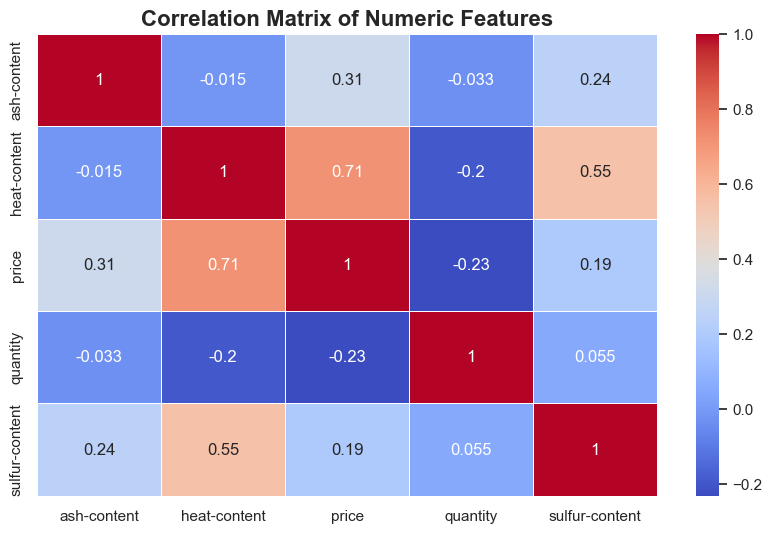

In [39]:
corr_matrix = df[['ash-content', 'heat-content', 'price', 'quantity', 'sulfur-content']].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features', fontsize=16, fontweight='bold')
plt.show()

## 9. Stacked Area Plot of Quantity Over Time by Coal Rank
This stacked area plot shows the total coal quantity over time, separated by coal rank. The colors stack on top of each other to show how the contributions of each coal rank have changed over time.

<Figure size 1000x600 with 0 Axes>

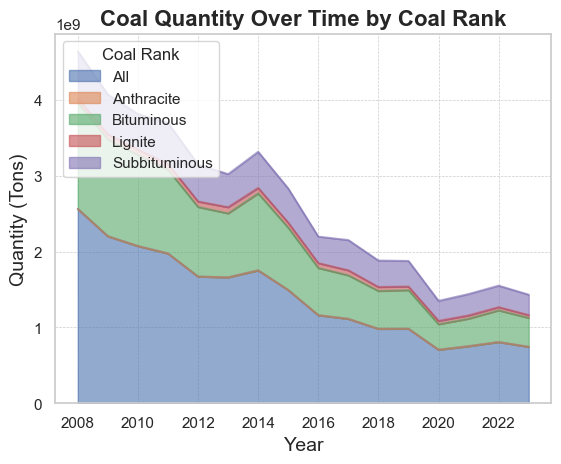

In [42]:
# Aggregate data to sum quantity by period and coal rank
quantity_over_time = df.groupby(['period', 'coalRankDescription'])['quantity'].sum().unstack()

# Plot stacked area chart
plt.figure(figsize=(10, 6))
quantity_over_time.plot.area(stacked=True, alpha=0.6)
plt.title('Coal Quantity Over Time by Coal Rank', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Quantity (Tons)', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(title='Coal Rank', loc='upper left')
plt.show()


## 10. Donut Chart of Coal Rank Distribution
The donut chart provides an appealing alternative to the pie chart, showcasing the distribution of different coal ranks across the dataset. The hollow center makes the visualization more unique and easier to interpret.

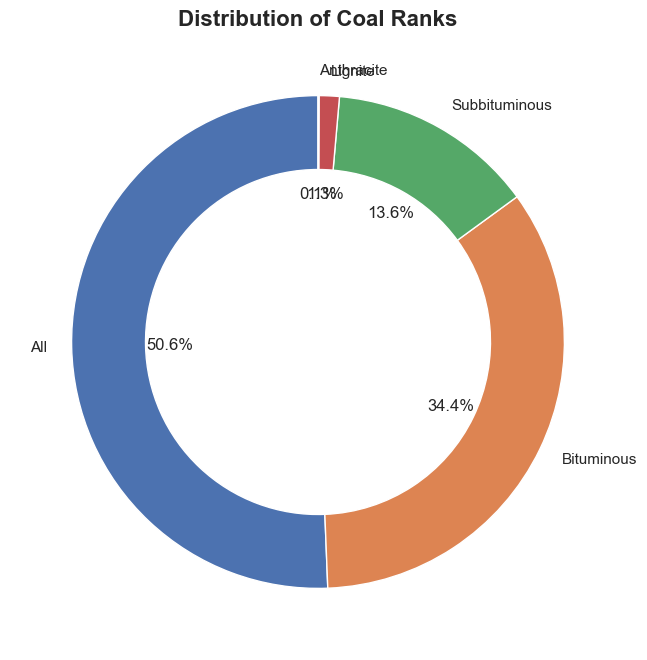

In [43]:

coal_rank_counts = df['coalRankDescription'].value_counts()

# Plot Donut chart
plt.figure(figsize=(8, 8))
plt.pie(coal_rank_counts, labels=coal_rank_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))
plt.title('Distribution of Coal Ranks', fontsize=16, fontweight='bold')
plt.gca().set_aspect('equal')  
plt.show()
